# U-Net Convolutional Neural Network (CNN)
# Prediciting a full-sized synthetic & TEM images
#### Ross Carmichael
#### 19/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import cv2
from MightyMosaic import MightyMosaic

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
model = tf.keras.models.load_model('saved_model/model_1.3_50_epochs')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

## Load in some images to be segmented

In [3]:
def load_data(path, tif=False):
    if tif:
        images = sorted(glob(os.path.join(path, "*.tif")))
        return images
    else:
        images = sorted(glob(os.path.join(path, "*.png")))
        return images

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = image.astype(np.float32)
    #image = np.expand_dims(image, axis=0)

    return image

In [4]:
path = "./full-size/synthetic/"

# File paths
images = load_data(path)
print(f"Images: {len(images)}")

synthetic_images = [read_image(image) for image in images]
print(synthetic_images[0].shape)

Images: 6
(512, 512, 3)


## Split the full-sized images into mosaics and predict

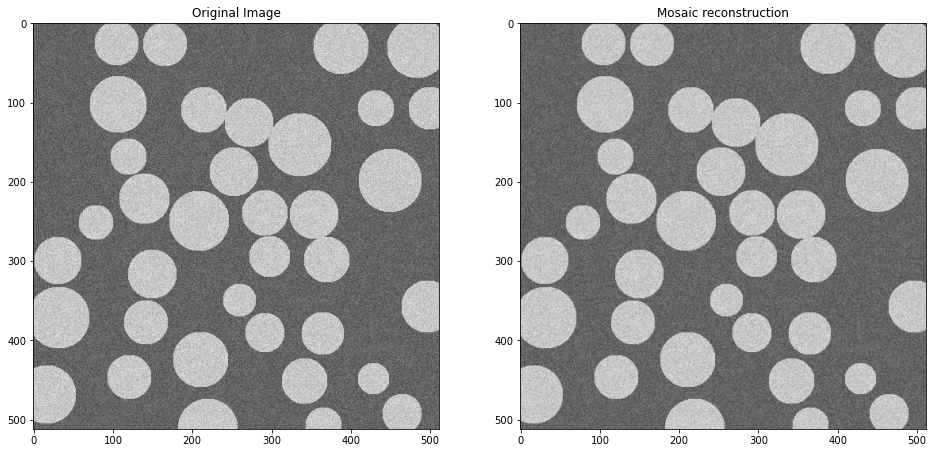

Mosaic shape: (16, 16, 128, 128, 3)


In [5]:
mosaic1 = MightyMosaic.from_array(synthetic_images[0], (128,128), overlap_factor=4, fill_mode='reflect')
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic1.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic1.shape))

In [6]:
prediction = mosaic1.apply(model.predict, progress_bar=True)

In [7]:
fused_prediction = prediction.get_fusion()
labels1 = np.argmax(fused_prediction, axis=-1)

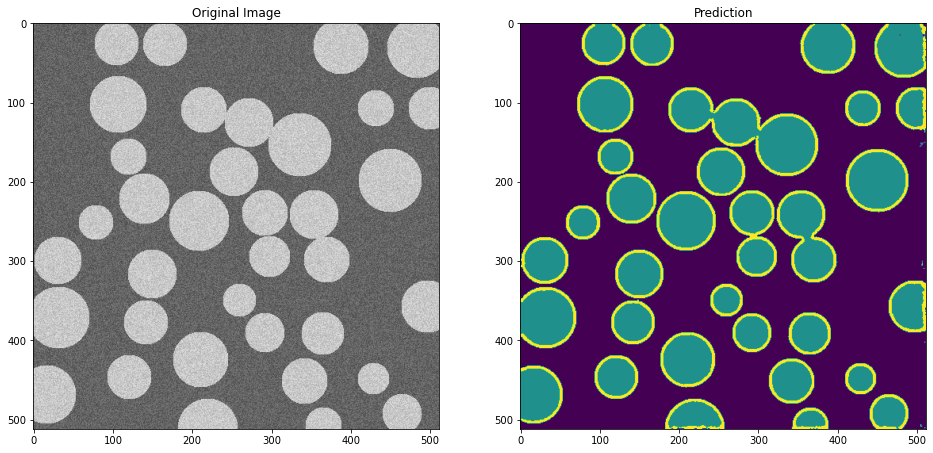

In [8]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])

plt.subplot(122)
plt.title("Prediction")
plt.imshow(labels1, interpolation='bilinear')
plt.show()

## Try with real TEM images now

In [9]:
path = "./full-size/tem/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

tem_images = [read_image(image) for image in images]
print(tem_images[0].shape)

tem_images = [1-img for img in tem_images]

Images: 8
(4096, 4096, 3)


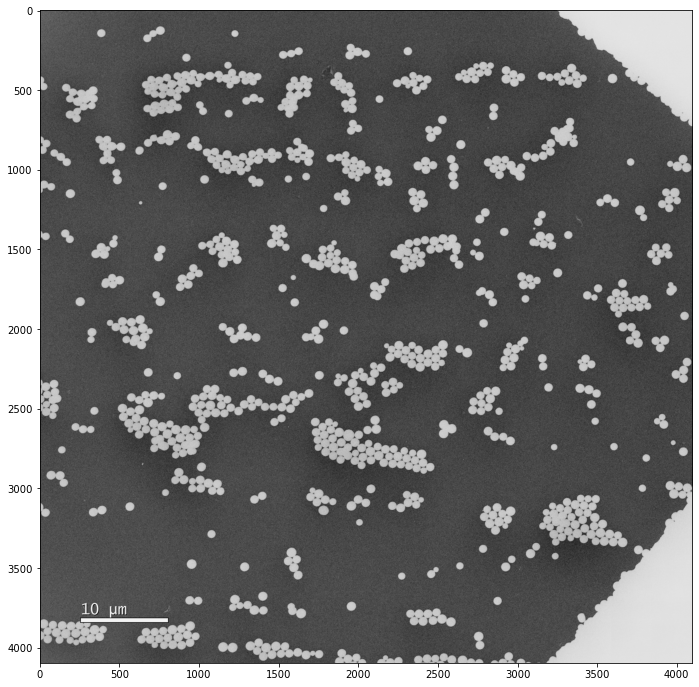

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(tem_images[0])
plt.show()

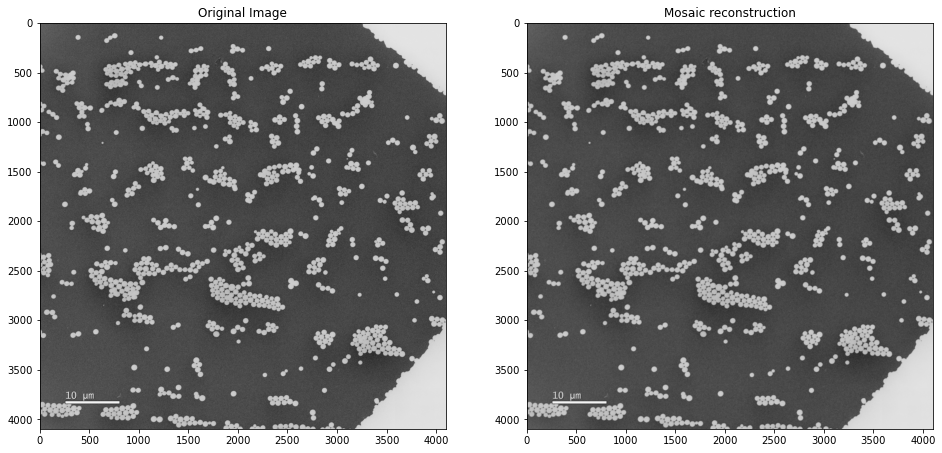

Mosaic shape: (64, 64, 128, 128, 3)


In [11]:
mosaic2 = MightyMosaic.from_array(tem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(tem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic2.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic2.shape))

In [12]:
prediction = mosaic2.apply(model.predict, progress_bar=True)

In [13]:
fused_prediction = prediction.get_fusion()
labels2 = np.argmax(fused_prediction, axis=-1)

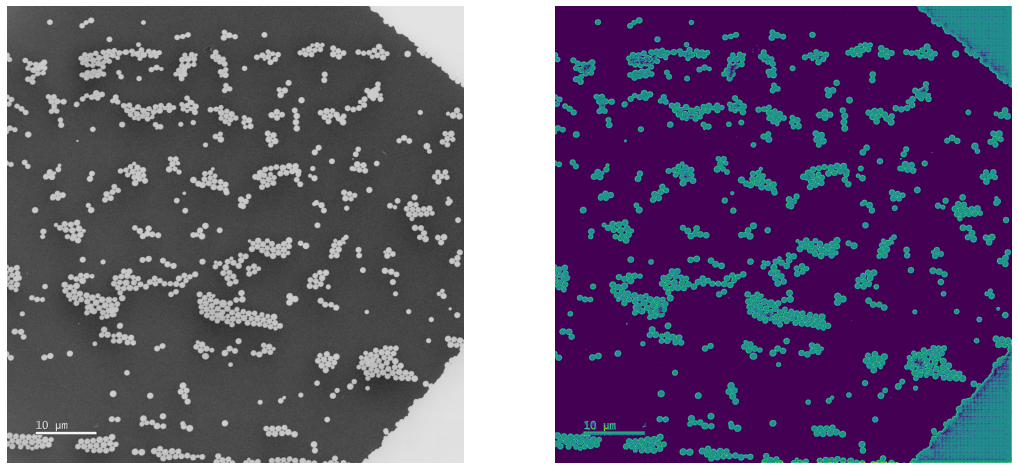

In [14]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(tem_images[0])
axs[0].axis('off')
axs[1].imshow(labels2)
axs[1].axis('off')
plt.show()

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels2*127)
plt.show()

## Run all TEM images through 

In [15]:
for i, tem_image in enumerate(tem_images):
    print(str(i+1) + ' of ' + str(len(tem_images)))
    
    # Mosaic and predict
    mosaic = MightyMosaic.from_array(tem_image, (128,128), overlap_factor=2, fill_mode='reflect')
    prediction = mosaic.apply(model.predict, progress_bar=True)
    
    clear_output()
    
    # Fuse and get labels
    fused_prediction = prediction.get_fusion()
    labels = np.argmax(fused_prediction, axis=-1)

    name = os.path.split(images[i])[-1]
    
    cv2.imwrite("segmented_" + name[:-4] + ".tif", labels*127)